# Narrative Verbs in Barwar
### Geoffrey Khan and Cody Kingham

<a href="https://github.com/CambridgeSemiticsLab"><img src="../docs/images/CambridgeU_BW.png" height="100pt" width="200pt" align='left'></a>

In [1]:
! echo "last updated"; date

last updated
Wed  5 Feb 2020 14:54:48 GMT


## Introduction

In the story corpus narratives are told using two past verbal forms: qṭilɛle (perfect) and qṭille (preterite). These forms interchange. It seems the qṭille form clusters around the onset of narratives in a section of narrative that sets the scene and so has a concentration of adverbials.

## Research Questions
Search for four sets of verbs (i) qṭilɛle form and (ii) qṭille form, (iii) qəm-qaṭəlle, (iv) initial /ʾ/ qaṭəl forms, i.e. qaṭəl forms beginning with ʾa-. 

Look for the following correlations between each of these groups and:
1. How often are such forms clause-initial, i.e. without an explicit subject noun or other constituent before them? This could be established by checking whether the string is immediately preceded by .| or ,|  

2. How often are these strings accompanied by an adverbial in the same sentence? Typical narrative adverbials are:

```
Adverbs containing the word yoma ‘day’ or yome ‘days’ or yomət ‘the day of’
b-lɛle ‘at night’
qedamta ‘in the morning’
mbadla ‘early in the morning’
ʾaṣərta ‘in the evening’
xarθa ‘afterwards’
ga, gaye ‘time, times’
xa-ga
```

## Technical Brief

In this notebook, we will use the [NENA text-corpus](https://github.com/CambridgeSemiticsLab/nena_corpus) in a [Text-Fabric format](https://github.com/CambridgeSemiticsLab/nena_tf) (for TF see [here](https://github.com/annotation/text-fabric)). Our corpus contains a number of linguistic encodings which will be useful for the analysis, especially: 

1. word tokenization
2. intonation group boundaries
3. sentence tokenization

These linguistic units are modeled as nodes within a graph. The nodes have associated features that can be called during the analysis. For example, a word has a plain-text feature that can be called for interacting with string text. The `text-fabric` Python module provides a set of classes and methods for reading in this graph and navigating the nodes and features. We will especially make heavy use of the `F` ("feature"), `L` ("level"), and `T` ("text") classes for navigating features, hierarchical levels, and plain text data.

The principle task is to identify verbs of qṭilɛle (perfect) and qṭille (preterite). To do this, we have a list of endings we can expect to find:

```
(i) For qṭilɛle forms search for strings ending in -ɛle and -ɛla (i.e. 3ms and 3fs). The hyphen means a wild card, i.e. any characters within the same word.

(ii) For qṭille forms search for strings ending in -ele, -ela, -ble, -bla, -dle, -dla, -fle, -fla, -gle, -gla, -jle, -jla, -kle, -kla, -mle, -mla, -nne, -nna, -ple, -pla, -qle, -qla, -rre, -rra, -sle, -sla, -ṣle, -ṣla, -tle, -tla, -ṭle, -ṭla, -wle, -wla, -xle, -xla, -zle, -zla. The hyphen means a wild card, i.e. any characters within the same word. This search may pull out lots of inappropriate examples with -L suffixes that are ob-jects, so one way of refining the results would be to add i before consonants, i.e. -ible, -ibla, -idle, -idla etc. The /i/ is the stem vowel of the peʿal form (the basic form).

(iii) For qəm-qaṭəlle forms search for forms beginning with qəm- in the results of the search for group (ii).

(iv) For qaṭəl forms beginning with ʾa-, I suggest you search for the onsets of the most common verbs ʾazə-, ʾazi (to go), ʾamər, ʾamr- (to say), ʾaθ- (to come), ʾasəq, ʾasq- ‘to go up’, ʾaxəl, ʾaxl- ‘to eat’, ʾarəq, ʾarq- ‘to run’.
```

For the string matching we can use the `re` Python module. All other rules and processing can be done with Python code. We will seek to store and visualize the resulting data using the standard data science modules: `pandas` and `matplotlib`. 

<hr>

# Python

In [85]:
# helper modules
import re
import csv
import collections # advanced data containers
import unicodedata

# data science modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# custom modules
from positions import Positions
from significance import contingency_table
from pca import apply_pca

# Text-Fabric and corpus load
from tf.app import use
nena = use('nena')
F, L, T = nena.api.F, nena.api.L, nena.api.T

	connecting to online GitHub repo annotation/app-nena ... connected
Using TF-app in /Users/cody/text-fabric-data/annotation/app-nena/code:
	#9ec58f223a6ba6817347279da277c1efadae550a (latest commit)
	connecting to online GitHub repo CambridgeSemiticsLab/nena_tf ... connected
Using data in /Users/cody/text-fabric-data/CambridgeSemiticsLab/nena_tf/tf/0.01:
	rv0.032=#dd02c45f4294b97f9ecd8d4c3809aaf4153e2843 (latest release)
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used


Below we access the first word in the NENA corpus to show an example of how we will maneuver the data.

In [52]:
first_word = L.u(1, 'word')[0]

print(first_word)

739771


Note the number above, which is a unique identifier for this word. That number is used to lookup the features. Below is an example of using `T` to get a plain-text representation of this word.

In [53]:
T.text(first_word)

'xá-ga '

And next we show the node but with the `trans_f` feature accessed.

In [54]:
F.trans_f.v(first_word)

"xa'-ga"

Note that the `.v` refers to the "value" of the feature.

To aid the input of verb ending patterns, we will use this one-to-one transcription feature `trans_f`. The validated patterns can be stored in the dictionary below.

In [55]:
verb_patterns = {} # a dictionary for storing all verb patterns
verbs = collections.defaultdict(list)

## qṭilɛle forms

```
(i) For qṭilɛle forms search for strings ending in -ɛle and -ɛla (i.e. 3ms and 3fs). The hyphen means a wild card, i.e. any characters within the same word.
```

In [56]:
barwar = nena.search('dialect dialect=Barwar')[0][0] # get Barwar dialect node

  0.00s 1 result


In [57]:
qtilele = verb_patterns['qtilele'] = re.compile(r'.*\$le$|.*\$la$')

# find words that match the qtilelele pattern 
for word in L.d(barwar,'word'):
    if qtilele.match(F.trans_f.v(word)): # test match
        verbs['qtilele'].append(word) # save hit
        
print(f'{len(verbs["qtilele"])} matches found...')

1827 matches found...


In order to sample the results, we write a short function to show them in context.

In [58]:
def get_sample(words, **tf_kwargs):
    """Show words and their contexts"""
    for i,w in enumerate(words):
        sentence = L.u(w, 'sentence')[0]
        nena.plain(sentence, **tf_kwargs, highlights={w})

We will look at the first 10 results.

In [59]:
get_sample(verbs['qtilele'][:10])

### Further examination

We want to export these forms to a spreadsheet so they can be examined more closely. There should be two kinds of spreadsheets. The first kind is an exhaustive list of all results, organized alphabetically. The second list contains a condensed list of all unique tokens/surface-forms along with their frequencies within the results. 

We prepare two functions for each of these tasks which we can also use throughout the study.

In [60]:
nena.sectionStrFromNode(1)

'Barwar, A Hundred Gold Coins, Ln. 1'

In [61]:
def normalize_nena(word):
    """Strip accents and spaces from NENA text on a node.
    
    Args:
        word: a node number to get normalized text
    """
    accents = '\u0300|\u0301|\u0304|\u0306|\u0308|\u0303'
    norm = F.text.v(word).replace(F.end.v(word),'')
    norm = unicodedata.normalize('NFD', norm) # decompose for accent stripping
    norm = re.sub(accents, '', norm) # strip accents
    return norm
    
def writecsv(data, filename, sep='\t'):
    """Writer function for dict spreadsheet data"""
    with open(filename, 'w', encoding='utf16') as outfile:
        header = data[0].keys()
        writer = csv.DictWriter(outfile, delimiter=sep, fieldnames=header)
        writer.writeheader()
        writer.writerows(data)
    
def export_long_results(results, filename, sep='\t'):
    """Export an exhaustive list of results"""
    # gather all data from words
    data = []
    for word in results:
        plain, trans = T.text(word), F.trans_f.v(word)
        sentence = T.text(L.u(word,'sentence')[0])
        ref = nena.sectionStrFromNode(word)
        data.append({
            'match': plain, 
            'sentence': sentence, 
            'ref': ref,
            'node': word,
        })
    # sort it and export
    data = sorted(data, key=lambda k: k['match'])
    writecsv(data, filename, sep)
        
def export_summary_results(results, filename, sep='\t'):
    """Export a summarized list"""
    token_counts = collections.Counter()
    for word in results:
        plain = normalize_nena(word)
        token_counts[plain] += 1
    data = [
        {'token': tok, 'frequency': count} 
            for tok, count in token_counts.most_common()
    ]
    writecsv(data, filename, sep)

We make the export below.

In [62]:
export_long_results(verbs['qtilele'], 'inspect/qtilele.tsv')
export_summary_results(verbs['qtilele'], 'inspect/qtilele_summary.tsv')

## Filter with Semantic Vector Space

We find a lot of false positives in the `qtilele` dataset. For instance, a lot of nominal items are accidentally selected. We will now attempt to filter terms in a more sophisticated way. We will construct a semantic vector space based on N-grams. 

N-grams are counts of a given word's collocational tendencies based on a given window of N-words. We write a function that retrieves a window of words around a given word. We use that function to gather the data. That data will then be used to sort words into a space. We hope to see some separation of verbal and nominal elements, which would allow us to have greater accuracy with our simple pattern searches.

In [63]:
def get_window(word, window=3, context='sentence'):
    """Build a contextual window, return context words.
    
    Args:
        word: a TF word node
    """
    context = L.u(word, context)[0]
    P = Positions(word, L.d(context, 'word')).get
    fore = list(range(-window, 0))
    back = list(range(1, window+1))
    conwords = []
    for pos in (fore + back):
        cword = P(pos)     
        if cword:
            conwords.append((cword, pos))
    return conwords

### Gather the N-grams

In [64]:
def ngram_text(word, pos):
    # stringify a context word
    text = normalize_nena(word)
    return f'{pos}.{text}'

word_contexts = collections.defaultdict(lambda:collections.Counter())

for word in verbs['qtilele']:
    text = normalize_nena(word)
    context = get_window(word)
    for nword, npos in context:
        ngram = ngram_text(nword,npos)
        word_contexts[text][ngram] += 1

In [200]:
wordcons = pd.DataFrame(word_contexts).fillna(0).T

In [201]:
wordcons

,-2.siqa,-1.l-gare,1.ʾəč̣č̣i-u,2.ʾəč̣č̣a,3.dawe,1.xera,2.b-gane,3.diye-u,-1.qimɛle,1.ʾan-baṭaniye,...,1.ṭḷaθi,2.ləxme,3.gu-čanta,-1.tarɛxu,-2.gwirəlla,-1.štayɛla-w,1.xaraya,1.ða-dukθa,2.daqiqta,3.la-mṣət
dəryɛle,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
muθɛθɛla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ʾəθyɛle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
qimɛle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lwišɛle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pč̣ilɛle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
hawnantɛla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
praqɛla,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ʾaw-tiwɛle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Only select samples > 5 observations

In [207]:
data = wordcons[wordcons.sum(1) > 5].dropna()

data.shape

(202, 3797)

### Normalize the Counts

We normalize the counts with a measure of statistical association. The $\Delta P$ measure is an asymmetrical measure of association that includes contingency information (see Ellis 2006). This is a well-suited measure for this project.

In [208]:
ct = contingency_table(data)

In [209]:
a = data
b = ct['b']
c = ct['c']
d = ct['d']

In [210]:
delta_p = (a/(a+b)) - (c/(c+d)).fillna(0)

In [211]:
delta_p

,-2.siqa,-1.l-gare,1.ʾəč̣č̣i-u,2.ʾəč̣č̣a,3.dawe,1.xera,2.b-gane,3.diye-u,-1.qimɛle,1.ʾan-baṭaniye,...,1.ṭḷaθi,2.ləxme,3.gu-čanta,-1.tarɛxu,-2.gwirəlla,-1.štayɛla-w,1.xaraya,1.ða-dukθa,2.daqiqta,3.la-mṣət
dəryɛle,0.490434,0.490434,0.990435,0.990435,0.990435,0.990435,0.990435,0.990435,0.016679,0.990435,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ʾəθyɛle,-0.046000,-0.046000,-0.045991,-0.045991,-0.045991,-0.045991,-0.045991,-0.045991,-0.046340,-0.045991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qimɛle,-0.119886,-0.119886,-0.119862,-0.119862,-0.119862,-0.119862,-0.119862,-0.119862,-0.120771,-0.119862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lwišɛle,-0.001425,-0.001425,-0.001425,-0.001425,-0.001425,-0.001425,-0.001425,-0.001425,-0.001435,-0.001425,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ʾu-tiwɛle,-0.004681,-0.004681,-0.004681,-0.004681,-0.004681,-0.004681,-0.004681,-0.004681,-0.004716,-0.004681,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lɛle,-0.001628,-0.001628,-0.001628,-0.001628,-0.001628,-0.001628,-0.001628,-0.001628,-0.001640,-0.001628,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
drayɛla,-0.002850,-0.002850,-0.002849,-0.002849,-0.002849,-0.002849,-0.002849,-0.002849,-0.002871,-0.002849,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qiθɛle,-0.001221,-0.001221,-0.001221,-0.001221,-0.001221,-0.001221,-0.001221,-0.001221,-0.001230,-0.001221,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ferəssɛle,-0.002646,-0.002646,-0.002646,-0.002646,-0.002646,-0.002646,-0.002646,-0.002646,-0.002666,-0.002646,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cluster Analysis

Dimensionality reduction with PCA

In [80]:
clust_data = delta_p.T

clust_data

,-2.siqa,-1.l-gare,1.ʾəč̣č̣i-u,2.ʾəč̣č̣a,3.dawe,1.xera,2.b-gane,3.diye-u,-1.qimɛle,1.ʾan-baṭaniye,...,1.ṭḷaθi,2.ləxme,3.gu-čanta,-1.tarɛxu,-2.gwirəlla,-1.štayɛla-w,1.xaraya,1.ða-dukθa,2.daqiqta,3.la-mṣət
dəryɛle,0.020663,0.020663,0.020833,0.020833,0.020833,0.020833,0.020833,0.020833,0.014353,0.020833,...,-0.000171,-0.000171,-0.000171,-0.000171,-0.000171,-0.000171,-0.000171,-0.000171,-0.000171,-0.000171
muθɛθɛla,-0.000338,-0.000338,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.006600,-0.000169,...,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169
ʾəθyɛle,-0.000352,-0.000352,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176,-0.006859,-0.000176,...,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176,-0.000176
qimɛle,-0.000376,-0.000376,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.007327,-0.000188,...,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188
lwišɛle,-0.000339,-0.000339,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.006605,-0.000169,...,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pč̣ilɛle,-0.000338,-0.000338,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.006600,-0.000169,...,-0.000169,-0.000169,-0.000169,0.333333,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169
hawnantɛla,-0.000338,-0.000338,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.006600,-0.000169,...,-0.000169,-0.000169,-0.000169,-0.000169,0.333333,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169
praqɛla,-0.000338,-0.000338,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.006600,-0.000169,...,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,0.333333,-0.000169,-0.000169,-0.000169,-0.000169
ʾaw-tiwɛle,-0.000338,-0.000338,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.006598,-0.000169,...,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,-0.000169,1.000000,-0.000169,-0.000169,-0.000169


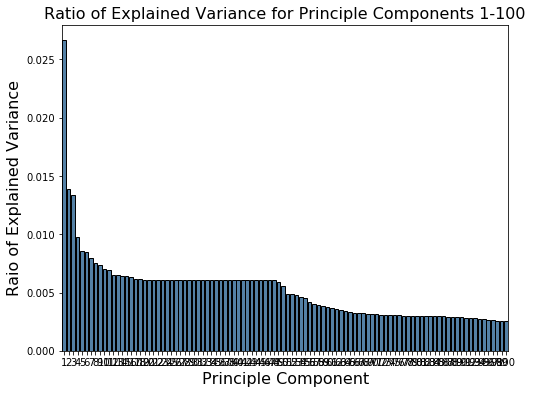

In [121]:
pca, loadings = apply_pca(clust_data, 0, 1, components=100)

In [126]:
links = linkage(pca, metric='cosine', method='complete')

In [ ]:
plt.figure(figsize=(40, 20))
dendrogram(links, labels=pca.index, )#orientation='right')
#plt.savefig('verb_clusters.png', dpi=350, bbox_inches='tight')
#plt.show()

In [136]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pca)

In [140]:
pca.shape

(537, 100)

In [164]:
clusters = pd.concat([pd.Series(pca.index), pd.Series(kmeans.labels_)], axis=1)
clusters.columns = ['word', 'cluster']
clusters

,word,cluster
0,dəryɛle,0
1,muθɛθɛla,0
2,ʾəθyɛle,0
3,qimɛle,0
4,lwišɛle,0
...,...,...
532,pč̣ilɛle,0
533,hawnantɛla,0
534,praqɛla,0
535,ʾaw-tiwɛle,0


In [165]:
clusters[clusters.cluster == 0]

,word,cluster
0,dəryɛle,0
1,muθɛθɛla,0
2,ʾəθyɛle,0
3,qimɛle,0
4,lwišɛle,0
...,...,...
532,pč̣ilɛle,0
533,hawnantɛla,0
534,praqɛla,0
535,ʾaw-tiwɛle,0


In [166]:
clusters[clusters.cluster == 1]

,word,cluster
246,kaporɛle,1
254,šeðanɛle,1
290,zdilɛle,1
510,šluxayɛle,1
